In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image


In [2]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

In [3]:
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [4]:
print(keras.__version__)

2.10.0


In [4]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
SIZE=64
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [6]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(5))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  


C:\Users\Manoj kumar\AppData\Local\Temp\ipykernel_18664\3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


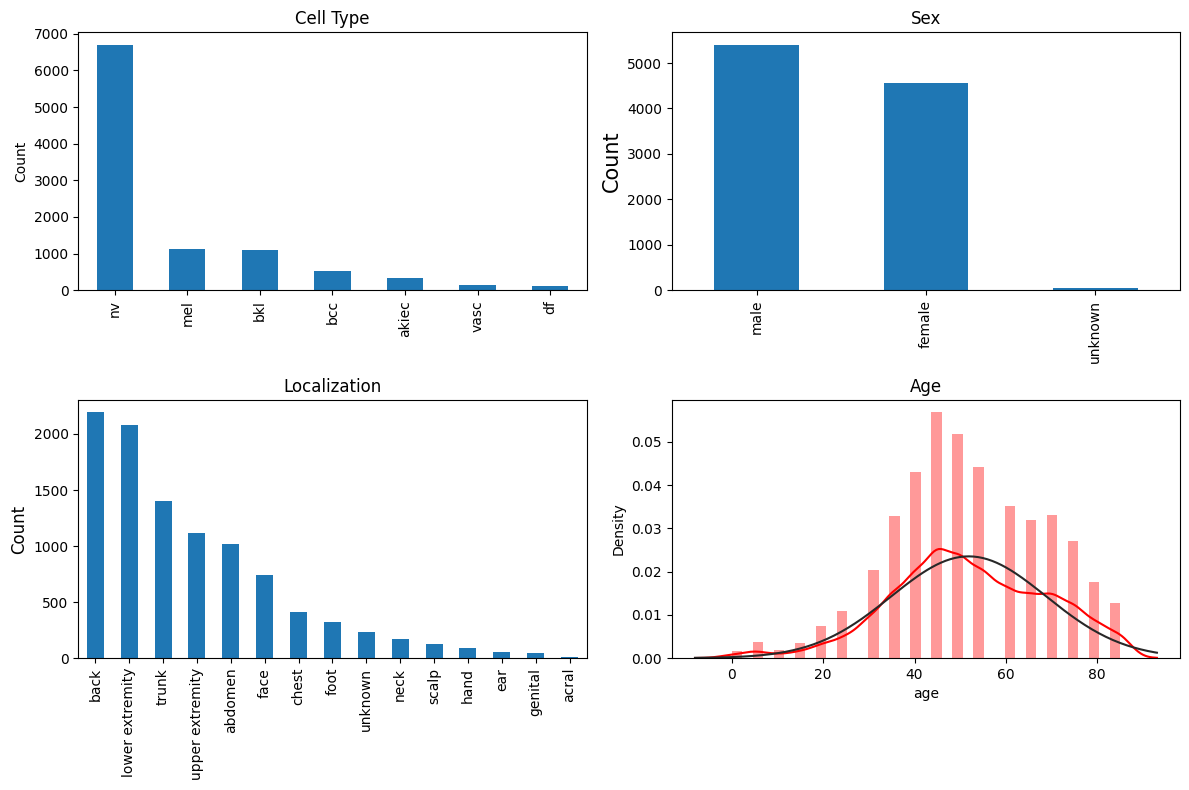

In [7]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [9]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())


0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


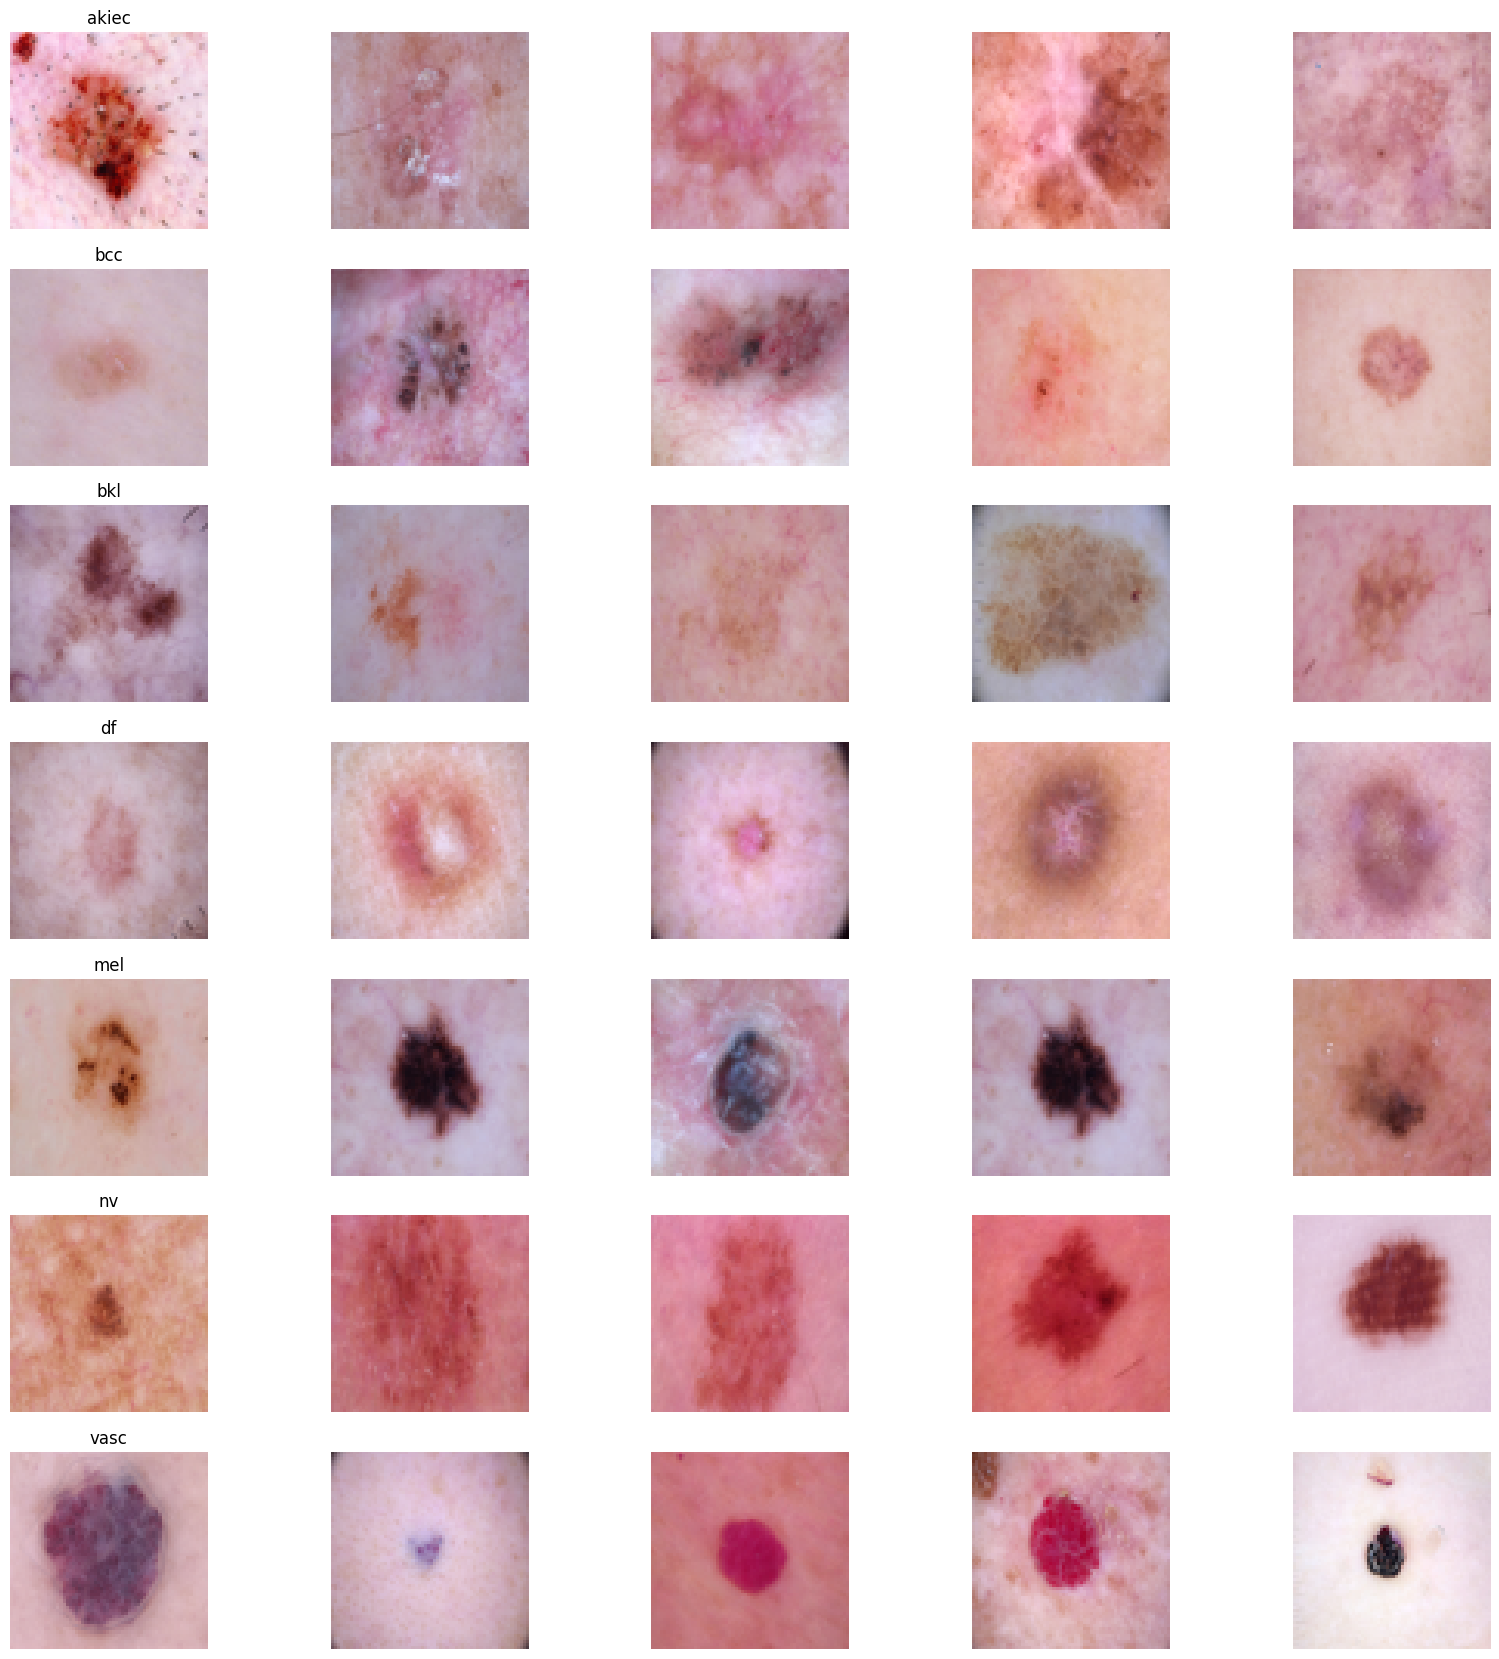

In [10]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/', '*', '*.jpg'))}

skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


n_samples = 5  

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])

        c_ax.axis('off')

In [11]:

X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. 
Y=skin_df_balanced['label']  
Y_cat = to_categorical(Y, num_classes=7) 

x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [12]:
num_classes = 7
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

In [14]:
batch_size = 16 
epochs = 100

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)



Epoch 1/100
165/165 - 57s - loss: 1.7619 - acc: 0.2636 - val_loss: 1.7502 - val_acc: 0.2651 - 57s/epoch - 343ms/step
Epoch 2/100
165/165 - 58s - loss: 1.6938 - acc: 0.3078 - val_loss: 1.6625 - val_acc: 0.3371 - 58s/epoch - 349ms/step
Epoch 3/100
165/165 - 58s - loss: 1.5369 - acc: 0.3939 - val_loss: 1.5446 - val_acc: 0.3634 - 58s/epoch - 352ms/step
Epoch 4/100
165/165 - 58s - loss: 1.4486 - acc: 0.4236 - val_loss: 1.3959 - val_acc: 0.4571 - 58s/epoch - 353ms/step
Epoch 5/100
165/165 - 59s - loss: 1.3246 - acc: 0.4888 - val_loss: 1.3102 - val_acc: 0.4811 - 59s/epoch - 358ms/step
Epoch 6/100
165/165 - 59s - loss: 1.3029 - acc: 0.4937 - val_loss: 1.2455 - val_acc: 0.4960 - 59s/epoch - 355ms/step
Epoch 7/100
165/165 - 57s - loss: 1.2019 - acc: 0.5337 - val_loss: 1.2353 - val_acc: 0.5131 - 57s/epoch - 348ms/step
Epoch 8/100
165/165 - 57s - loss: 1.1743 - acc: 0.5478 - val_loss: 1.2561 - val_acc: 0.5223 - 57s/epoch - 346ms/step
Epoch 9/100
165/165 - 58s - loss: 1.1031 - acc: 0.5794 - val_los

In [15]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 4s 141ms/step - loss: 0.9131 - acc: 0.7440
Test accuracy: 0.7440000176429749


In [16]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 


28/28 [==============================] - 4s 132ms/step


<AxesSubplot: >

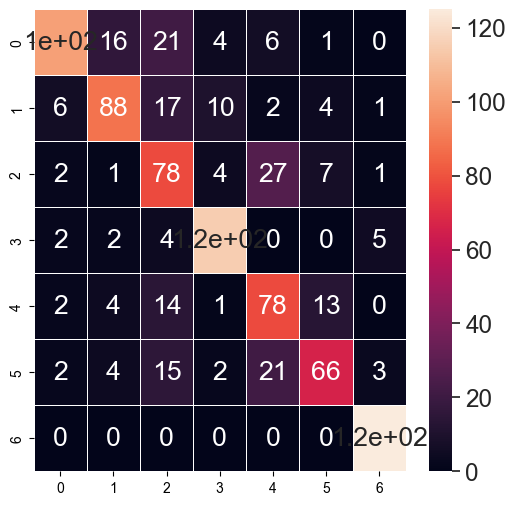

In [17]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


Text(0, 0.5, 'Fraction of incorrect predictions')

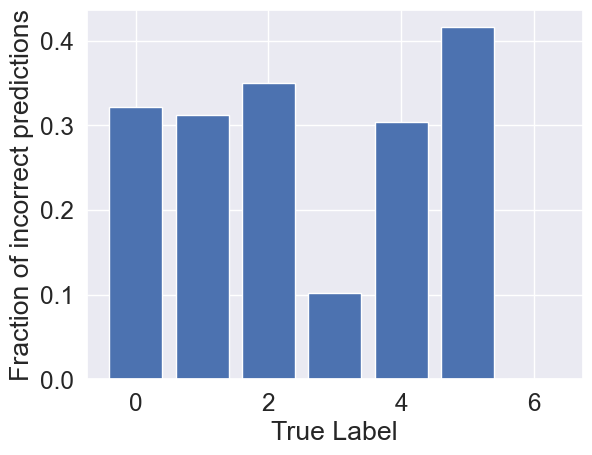

In [18]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [20]:
import cv2
img = 'ISIC_0034149.jpg'
img = cv2.resize(cv2.imread(img), (SIZE,SIZE)) / 255.0
prediction = model.predict(img.reshape(1,SIZE,SIZE,3))
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(prediction, axis = 1) 
# Convert test data to one hot vectors

y_true = np.argmax(prediction, axis = 1) 
print(y_true)


1/1 [==============================] - 0s 35ms/step
[6]


In [21]:
classes = {4: 'mel', 6: 'vasc', 2 :'bkl', 1:'bcc' , 5: 'nv', 0: 'akiec',  3: 'df'}
classes[y_true[0]]


'vasc'

In [24]:
import pickle
pickle.dump(model, open("model.pkl", "wb"))
# model = pickle.load(open("model.pkl", "rb"))

INFO:tensorflow:Assets written to: ram://d00ad5ba-fa0d-4a51-9298-b26410f0566b/assets


INFO:tensorflow:Assets written to: ram://d00ad5ba-fa0d-4a51-9298-b26410f0566b/assets


In [25]:
import joblib
filename = 'finalized_model.sav'
joblib.dump(model, filename)

 

INFO:tensorflow:Assets written to: ram://3a3f23b3-e070-4e75-9c7b-1936d0fa9d80/assets


INFO:tensorflow:Assets written to: ram://3a3f23b3-e070-4e75-9c7b-1936d0fa9d80/assets


['finalized_model.sav']

In [22]:
from keras.models import save_model

# you can write whatever you desire instead of 'my_model'
# model = Your trained model
model.save('mymodel')

INFO:tensorflow:Assets written to: mymodel\assets


INFO:tensorflow:Assets written to: mymodel\assets


In [23]:
from keras.models import load_model
model = load_model("my_model")

In [27]:
img = 'ISIC_0034149.jpg'
img = cv2.resize(cv2.imread(img), (SIZE,SIZE)) / 255.0
prediction = model.predict(img.reshape(1,SIZE,SIZE,3))
y_pred_classes = np.argmax(prediction, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(prediction, axis = 1) 
print(y_true)

1/1 [==============================] - 0s 78ms/step
[6 6 6 4 6 4 5 2 6]


In [1]:
import cv2
import glob
a=[]
classes = {4: 'mel', 6: 'vasc', 2 :'bkl', 1:'bcc' , 5: 'nv', 0: 'akiec',  3: 'df'}
for img in glob.glob("testdata/*.jpg"):
    img = cv2.resize(cv2.imread(img), (SIZE,SIZE)) / 255.0
    prediction = model.predict(img.reshape(1,SIZE,SIZE,3))

    y_pred_classes = np.argmax(prediction, axis = 1) 
    y_true = np.argmax(prediction, axis = 1) 
    a.append(y_true[0])


NameError: name 'SIZE' is not defined

In [33]:
classes = {4: 'mel', 6: 'vasc', 2 :'bkl', 1:'bcc' , 5: 'nv', 0: 'akiec',  3: 'df'}
for i in a:
    print(classes[i])

nv
vasc
nv
mel
bkl
